In [113]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [114]:
import numpy as np
import pandas as pd

In [115]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [116]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [117]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [118]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [119]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [120]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [121]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [122]:
#session.query(Measurement.date).order_by(Measurement.date).first().date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
latest_date

'2017-08-23'

In [123]:
latest_date = list(np.ravel(latest_date))[0]
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')

In [124]:
# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores
latest_year = int(dt.datetime.strftime(latest_date, '%Y'))
latest_month = int(dt.datetime.strftime(latest_date, '%m'))
latest_day = int(dt.datetime.strftime(latest_date, '%d'))
year_before = dt.date(latest_year, latest_month, latest_day) - dt.timedelta(days=365)



In [125]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

rain_data = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date >= year_before)
                  .order_by(Measurement.date)
                  .all())


In [126]:
# Save the query results as a Pandas DataFrame and set the index to the date column
rain_table = pd.DataFrame(rain_data)
rain_table = rain_table.set_index('date')

# Sort the dataframe by date
rain_table = rain_table.sort_index(ascending=True)

<function matplotlib.pyplot.show(*args, **kw)>

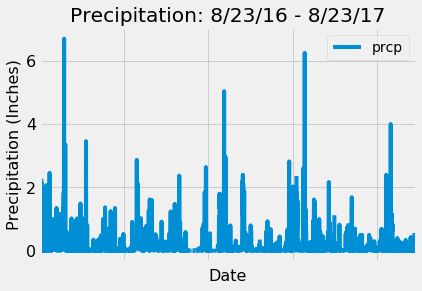

In [127]:
# Use Pandas Plotting with Matplotlib to plot the data

rain_graph=rain_table.plot(title="Precipitation: 8/23/16 - 8/23/17")
plt.locator_params(axis='x', nbins=6)
rain_graph.xaxis.set_major_formatter(plt.NullFormatter())
rain_graph.tick_params(axis='y', labelsize=16)
rain_graph.grid(True)
plt.ylabel("Precipitation (Inches)", size=16)
plt.xlabel("Date", size=16)
plt.savefig("../Precipitation.png")
plt.show

![precipitation](Images/precipitation.png)

In [128]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_table.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [129]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [130]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_data = (session.query(Measurement.station, func.count(Measurement.station))
                  .group_by(Measurement.station)
                  .order_by(func.count(Measurement.station).desc()).all())
station_data

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [131]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

station_id=station_data[0][0]
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                filter(Measurement.station == station_id).all()

[(54.0, 85.0, 71.66378066378067)]

In [132]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
t_results = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == station_id).\
                filter(Measurement.date >= year_before).all()
tobs_df = pd.DataFrame(t_results)
tobs_df.set_index('station', inplace=True)
tobs_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


![precipitation](Images/station-histogram.png)

<function matplotlib.pyplot.show(*args, **kw)>

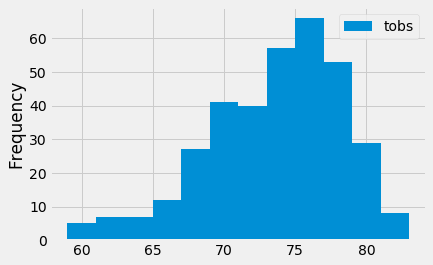

In [133]:
tobs_df.plot(kind='hist', bins=12)
plt.savefig("../StationTemps.png")
plt.show

In [134]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [135]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start='2015-05-11'
trip_end='2015-05-20'
trip_temp=calc_temps(trip_start, trip_end)
trip_temp

[(66.0, 73.90140845070422, 82.0)]

In [136]:
trip_df = pd.DataFrame(trip_temp, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']

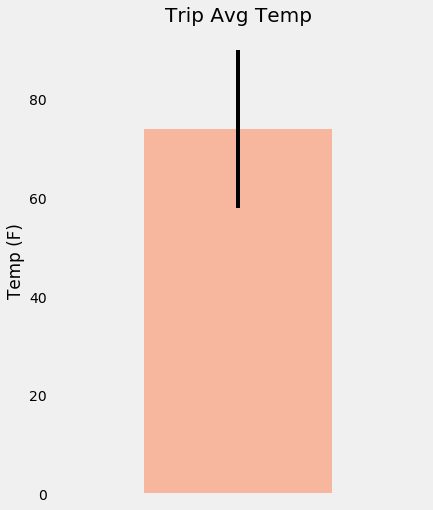

In [137]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.savefig("../TripTempSummary.png")
plt.show()


In [138]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

station_rain = (session.query(*sel)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= trip_start)
                   .filter(Measurement.date <= trip_end)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

station_rain_table = pd.DataFrame(np.array(station_rain))

station_rain_table = station_rain_table.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})

station_rain_table


,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",2.5400000000000005,21.3331,-157.8025,152.4
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.51,21.5213,-157.8374,7.0
2,USC00513117,"KANEOHE 838.1, HI US",0.4900000000000001,21.4234,-157.8015,14.6
3,USC00519281,"WAIHEE 837.5, HI US",0.49000000000000005,21.45167,-157.84888999999998,32.9
4,USC00519397,"WAIKIKI 717.2, HI US",0.14,21.2716,-157.8168,3.0
5,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",0.0,21.3152,-157.9992,0.9
6,USC00518838,"UPPER WAHIAWA 874.3, HI US",0.0,21.4992,-158.0111,306.6
7,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.0,21.33556,-157.71139,19.5


## Optional Challenge Assignment

In [139]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [140]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

start_date = "2020-05-11"
end_date = "2020-05-20"
start_num = int(start_date[-2:])
end_num = int(end_date[-2:])
trip_length = end_num - start_num + 1
start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')
date_list = [dt.datetime.strftime(start_date + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, trip_length)]


trip_normals = [daily_normals(date) for date in date_list]

trip_normals

[[(65.0, 73.61111111111111, 79.0)],
 [(65.0, 73.13793103448276, 79.0)],
 [(67.0, 73.14285714285714, 79.0)],
 [(63.0, 73.89285714285714, 80.0)],
 [(63.0, 73.69090909090909, 79.0)],
 [(68.0, 74.37931034482759, 80.0)],
 [(68.0, 74.45, 79.0)],
 [(68.0, 74.10714285714286, 82.0)],
 [(65.0, 73.80701754385964, 79.0)],
 [(68.0, 73.89655172413794, 79.0)]]

In [141]:
trip_normals = [np.array(normal[0]) for normal in trip_normals]
normals_table = pd.DataFrame(trip_normals)
normals_table["Date"] = date_list
normals_table = normals_table.set_index("Date")
normals_table = normals_table.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})

normals_table

,Low Temp,Avg Temp,High Temp
Date,,,
05-11,65.0,73.611111,79.0
05-12,65.0,73.137931,79.0
05-13,67.0,73.142857,79.0
05-14,63.0,73.892857,80.0
05-15,63.0,73.690909,79.0
05-16,68.0,74.379310,80.0
05-17,68.0,74.450000,79.0
05-18,68.0,74.107143,82.0
05-19,65.0,73.807018,79.0


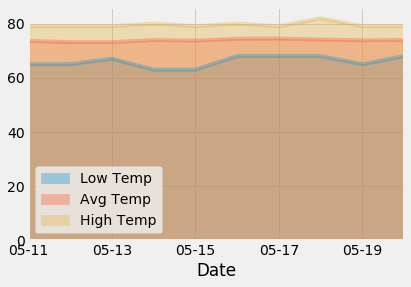

In [142]:
# Plot the daily normals as an area plot with `stacked=False`
normals_table.plot.area(stacked=False, alpha=.333)